[INFO] TFs available: 57 | TFs shown: 10


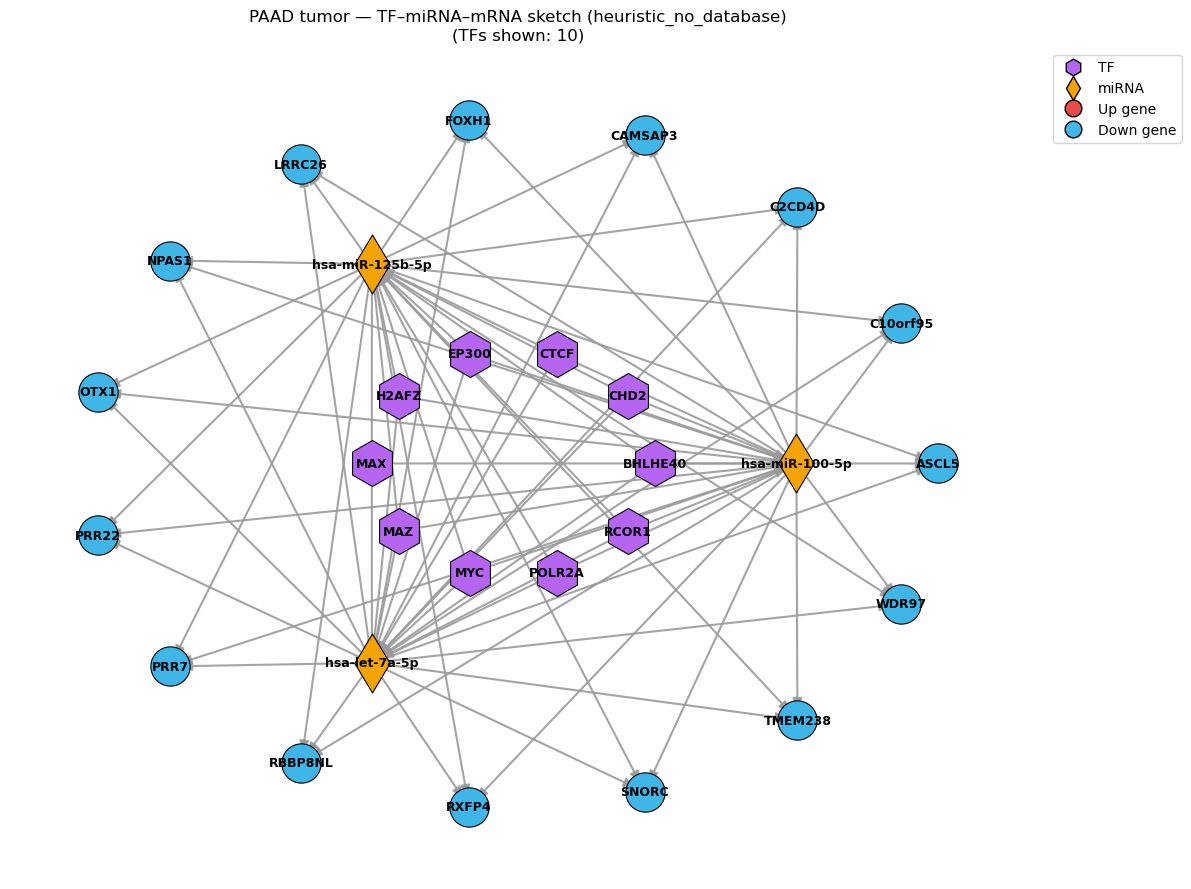

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/PAAD_TF_miRNA_mRNA_network_heuristic_no_database.png
TFs shown: 10 | miRNAs: 3 | genes shown: 15


In [1]:
# ================= TF–miRNA–mRNA network (PAAD tumor) ======================
# Hexagon=TF, diamond=miRNA, circle=gene; red=up, blue=down.

import os, re, math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

dea_path          = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_PAAD_Tumor_High_vs_Low_TREAT_QN_DET02_full_results.tsv"
tf_edges_path     = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/gene_attribute_edges.txt"
mirna_targets_path= "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/miRNA_targets.tsv"  
outdir            = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output"
os.makedirs(outdir, exist_ok=True)

MIR_SYMBOL          = "MIR100HG"
MIRNAS_OF_INTEREST  = ["hsa-miR-100-5p", "hsa-miR-125b-5p", "hsa-let-7a-5p"]
FDR_CUTOFF          = 0.05
LFC_CUTOFF          = 1.0
N_TF_SHOW           = 10     
TOP_PER_MIR_UP      = 10     
TOP_PER_MIR_DN      = 10
HEURISTIC_TOP_PER_MIR = 15  
SEED                = 13
PROJECT_TF_TO_MIRNAS= True   

def load_dea(path):
    df = pd.read_csv(path, sep="\t")
    sym_col = next((c for c in ["HGNC_symbol","Symbol","gene_symbol","Gene","gene_ID"] if c in df.columns), None)
    if sym_col is None:
        if "Unnamed: 0" in df.columns:
            df = df.rename(columns={"Unnamed: 0":"gene_ID"}); sym_col = "gene_ID"
        else:
            df["gene_ID"] = df.index.astype(str); sym_col = "gene_ID"
    if not {"logFC","adj.P.Val"}.issubset(df.columns):
        raise ValueError("DEA file must contain 'logFC' and 'adj.P.Val'.")
    df["label"] = df[sym_col].astype(str)
    sig = df[(df["adj.P.Val"] <= FDR_CUTOFF) & (df["logFC"].abs() >= LFC_CUTOFF)].copy()
    up   = sig[sig["logFC"] >=  LFC_CUTOFF].sort_values(["adj.P.Val","logFC"], ascending=[True, False])
    down = sig[sig["logFC"] <= -LFC_CUTOFF].sort_values(["adj.P.Val","logFC"], ascending=[True, True])
    return df, sig, up, down

def load_tf_db(path):
    try:
        df = pd.read_csv(path, sep=None, engine="python")
    except Exception:
        df = pd.read_csv(path, sep="\t")
    df.columns = [re.sub(r"\s+", "_", c.strip()) for c in df.columns]
    df.columns = [c.lower() for c in df.columns]
    if "targetgene" in df.columns:
        df = df[~df["targetgene"].astype(str).str.lower().eq("targetgene")]
    need = {"targetgene","transcriptionfactor"}
    if not need.issubset(df.columns):
        raise ValueError("TF table must have 'targetGene' and 'TranscriptionFactor'.")
    df = df.dropna(subset=list(need)).copy()
    df["targetgene"] = df["targetgene"].astype(str).str.strip()
    df["transcriptionfactor"] = df["transcriptionfactor"].astype(str).str.strip()
    if "weight" not in df.columns: df["weight"] = 1.0
    return df.rename(columns={"targetgene":"target","transcriptionfactor":"tf"})

def load_mirna_targets_optional(path):
    if not os.path.exists(path):
        return None
    try:
        df = pd.read_csv(path, sep=None, engine="python")
    except Exception:
        df = pd.read_csv(path, sep="\t")
    df.columns = [c.strip().lower() for c in df.columns]
    mir_col = next((c for c in df.columns if c in ["mirna","mir","mirna_name","microrna"]), None)
    tgt_col = next((c for c in df.columns if c in ["targetgene","target","gene","hgnc_symbol"]), None)
    if mir_col is None or tgt_col is None:
        return None
    df = df[[mir_col, tgt_col] + [c for c in df.columns if c not in [mir_col, tgt_col]]].copy()
    df.rename(columns={mir_col:"miRNA", tgt_col:"TargetGene"}, inplace=True)
    df["miRNA_norm"] = (df["miRNA"].astype(str)
                        .str.replace(r"\s+", "", regex=True)
                        .str.replace("^hsa-", "", regex=True)
                        .str.lower())
    df["TargetGene"] = df["TargetGene"].astype(str).str.strip()
    return df

dea, dea_sig, up_all, down_all = load_dea(dea_path)
tfdb = load_tf_db(tf_edges_path)
mirdb = load_mirna_targets_optional(mirna_targets_path)

def norm_miR(x): return x.replace(" ", "").replace("hsa-","").lower()
MIRNAS_NORM = [norm_miR(m) for m in MIRNAS_OF_INTEREST]


tf_to_mir = tfdb[tfdb["target"].str.upper() == MIR_SYMBOL.upper()].copy()
tfs_all = sorted(tf_to_mir["tf"].unique())

# Rank TFs by TF→TF out-degree within this TF set; 
tf_tf = tfdb[(tfdb["tf"].isin(tfs_all)) & (tfdb["target"].isin(tfs_all))][["tf","target"]]
if tf_tf.empty:
    tfs_show = tfs_all[:N_TF_SHOW]
else:
    outdeg = tf_tf.groupby("tf")["target"].nunique()
    tfs_show = sorted(tfs_all, key=lambda t: (-outdeg.get(t,0), t))[:N_TF_SHOW]

print(f"[INFO] TFs available: {len(tfs_all)} | TFs shown: {len(tfs_show)}")

# TF → miRNA edges 
tf_mi_edges = []
direct_tf_mi = tfdb[tfdb["target"].str.contains("^MIR", case=False, regex=True)]  # rare
if not direct_tf_mi.empty:
    for _,r in direct_tf_mi.iterrows():
        m = norm_miR(r["target"])
        if m in MIRNAS_NORM and r["tf"] in tfs_show:
            tf_mi_edges.append((r["tf"], r["target"]))
if PROJECT_TF_TO_MIRNAS:
    for tf in tfs_show:
        for m in MIRNAS_OF_INTEREST:
            tf_mi_edges.append((tf, m))
tf_mi_edges = sorted(set(tf_mi_edges))


deg_map = dea_sig.set_index("label")[["logFC","adj.P.Val"]]

mir_to_genes_show = []
mode = "validated"
if mirdb is not None:
    mirdb_sub = mirdb[mirdb["miRNA_norm"].isin(MIRNAS_NORM)].copy()
    mirdb_sub["miRNA_canon"] = mirdb_sub["miRNA_norm"].map(
        {norm_miR(k):k for k in MIRNAS_OF_INTEREST}
    ).fillna(mirdb_sub["miRNA"])
    mir_edges_all = mirdb_sub[mirdb_sub["TargetGene"].isin(deg_map.index)].copy()

    def pick_targets(mir_name_canon, top_up, top_dn):
        sub = mir_edges_all[mir_edges_all["miRNA_canon"]==mir_name_canon].merge(
            deg_map, left_on="TargetGene", right_index=True, how="left")
        up   = sub[sub["logFC"] >=  LFC_CUTOFF].sort_values(["adj.P.Val","logFC"], ascending=[True, False]).head(top_up)
        down = sub[sub["logFC"] <= -LFC_CUTOFF].sort_values(["adj.P.Val","logFC"], ascending=[True, True]).head(top_dn)
        return up, down

    for m in MIRNAS_OF_INTEREST:
        u, d = pick_targets(m, TOP_PER_MIR_UP, TOP_PER_MIR_DN)
        mir_to_genes_show.append(u.assign(direction="up", support="database"))
        mir_to_genes_show.append(d.assign(direction="down", support="database"))
else:
    mode = "heuristic_no_database"
    down_top = (dea_sig[dea_sig["logFC"] <= -LFC_CUTOFF]
                .sort_values(["adj.P.Val","logFC"], ascending=[True, True])
                .head(HEURISTIC_TOP_PER_MIR)[["label","logFC","adj.P.Val"]])
    for m in MIRNAS_OF_INTEREST:
        mir_to_genes_show.append(
            down_top.rename(columns={"label":"TargetGene"}).assign(
                miRNA_canon=m, direction="down", support="putative_heuristic"
            )
        )

mir_to_genes_show = (pd.concat(mir_to_genes_show, ignore_index=True)
                     if len(mir_to_genes_show) else
                     pd.DataFrame(columns=["miRNA_canon","TargetGene","logFC","adj.P.Val","direction","support"]))

tf_nodes   = sorted(set(tfs_show))
mir_nodes  = MIRNAS_OF_INTEREST
gene_nodes = sorted(set(mir_to_genes_show["TargetGene"]))

edges_plot = []
for tf, m in tf_mi_edges:
    edges_plot.append({"source": tf, "target": m, "etype":"TF_to_miRNA"})
for _, r in mir_to_genes_show.iterrows():
    edges_plot.append({
        "source": r["miRNA_canon"],
        "target": r["TargetGene"],
        "etype": "miRNA_to_gene",
        "logFC": float(r["logFC"]),
        "adj.P.Val": float(r["adj.P.Val"]),
        "direction": "up" if r["logFC"]>0 else "down",
        "support": r.get("support", mode)
    })
edges_plot = pd.DataFrame(edges_plot)

edges_plot.to_csv(os.path.join(outdir, f"PAAD_TF_miRNA_mRNA_edges_SHOWN_{mode}.csv"), index=False)
pd.DataFrame({"node": tf_nodes + mir_nodes + gene_nodes}).to_csv(
    os.path.join(outdir, f"PAAD_TF_miRNA_mRNA_nodes_SHOWN_{mode}.csv"), index=False
)

G = nx.DiGraph()
for t in tf_nodes:  G.add_node(t,   ntype="TF")
for m in mir_nodes: G.add_node(m,   ntype="miRNA")
for g in gene_nodes:
    if g in deg_map.index:
        dirn = "up" if deg_map.loc[g,"logFC"]>0 else "down"
    else:
        dirn = "NA"
    G.add_node(g, ntype="gene", direction=dirn)

for _, e in edges_plot.iterrows():
    G.add_edge(e["source"], e["target"], etype=e["etype"], direction=e.get("direction",""))

pos = nx.shell_layout(G, nlist=[tf_nodes, mir_nodes, gene_nodes], rotate=0)

plt.figure(figsize=(12,9))
nx.draw_networkx_edges(G, pos, edge_color="#9a9a9a", arrows=True, arrowsize=14,
                       arrowstyle='-|>', width=1.5, alpha=0.9)

def draw_nodes(nlist, shape, color, size):
    if nlist:
        nx.draw_networkx_nodes(G, pos, nodelist=nlist, node_shape=shape, node_color=color,
                               edgecolors="k", linewidths=0.8, node_size=size)

draw_nodes(tf_nodes,  shape="h", color="#B565F2", size=1100)  # TFs (hexagon)
draw_nodes(mir_nodes, shape="d", color="#F4A300", size=900)   # miRNAs (diamond)
genes_up   = [n for n in gene_nodes if G.nodes[n].get("direction")=="up"]
genes_down = [n for n in gene_nodes if G.nodes[n].get("direction")=="down"]
draw_nodes(genes_up,   shape="o", color="#E94B4B", size=800)  # up genes (red)
draw_nodes(genes_down, shape="o", color="#40B6E8", size=800)  # down genes (blue)

labels = {n:n for n in tf_nodes + mir_nodes + gene_nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_weight="bold")

from matplotlib.lines import Line2D
legend_elems = [
    Line2D([0],[0], marker='h', color='w', label='TF', markerfacecolor="#B565F2", markeredgecolor="k", markersize=12),
    Line2D([0],[0], marker='d', color='w', label='miRNA', markerfacecolor="#F4A300", markeredgecolor="k", markersize=12),
    Line2D([0],[0], marker='o', color='w', label='Up gene',   markerfacecolor="#E94B4B", markeredgecolor="k", markersize=12),
    Line2D([0],[0], marker='o', color='w', label='Down gene', markerfacecolor="#40B6E8", markeredgecolor="k", markersize=12),
]
plt.legend(handles=legend_elems, loc="upper left", bbox_to_anchor=(1.02, 1.0))
plt.title(f"PAAD tumor — TF–miRNA–mRNA sketch ({mode})\n"
          f"(TFs shown: {len(tf_nodes)})", fontsize=12)
plt.axis("off")
png_path = os.path.join(outdir, f"PAAD_TF_miRNA_mRNA_network_{mode}.png")
plt.tight_layout(); plt.savefig(png_path, dpi=300, bbox_inches="tight"); plt.show()
print(f"[WRITE] {png_path}")
print(f"TFs shown: {len(tf_nodes)} | miRNAs: {len(mir_nodes)} | genes shown: {len(gene_nodes)}")


In [5]:
import re
bn_tum  = os.path.basename(TUMOR_FILE).lower()
bn_norm = os.path.basename(NORMAL_FILE).lower()
if re.search(r"low[_-]?vs[_-]?high", bn_norm) and "logFC_norm" in merged.columns:
    merged["logFC_norm"] = -merged["logFC_norm"]

merged["dir_tum"]  = [_call(r.logFC_tum,  r.adj_tum)  for r in merged.itertuples()]
merged["dir_norm"] = [_call(r.logFC_norm, r.adj_norm) for r in merged.itertuples()]
merged["sig_tum"]  = merged["dir_tum"].ne("NS")
merged["sig_norm"] = merged["dir_norm"].ne("NS")
merged["delta_logFC"] = merged["logFC_tum"] - merged["logFC_norm"]

from scipy.stats import spearmanr, fisher_exact, binomtest
import numpy as np


common = merged.dropna(subset=["logFC_tum","logFC_norm"]).copy()
rho, p_rho = spearmanr(common["logFC_tum"], common["logFC_norm"])

# 2x2 (both significant only) and Fisher exact (alternative='greater' => concordance enrichment)
both_sig = merged[merged.sig_tum & merged.sig_norm].copy()
tbl = both_sig.groupby(["dir_tum","dir_norm"]).size().unstack(fill_value=0)
tbl = tbl.reindex(index=["UP","DOWN"], columns=["UP","DOWN"], fill_value=0).astype(int)
oddsratio, p_fisher = fisher_exact(tbl.values, alternative="greater")

# Sign test across ALL common genes 
k = int((np.sign(common["logFC_tum"]) == np.sign(common["logFC_norm"])).sum())
n = len(common)
p_sign = binomtest(k, n, 0.5, alternative="greater").pvalue

w(tbl.reset_index().melt(id_vars="dir_tum", var_name="dir_norm", value_name="n"), "direction_contingency_full")
stats = pd.DataFrame({
    "metric": ["spearman_rho","spearman_p","fisher_oddsratio","fisher_p","sign_agree_k","sign_agree_n","sign_test_p"],
    "value":  [rho, p_rho, oddsratio, p_fisher, k, n, p_sign]
})
w(stats, "concordance_stats")


[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/Paad_compare_py_min/direction_contingency_full.tsv
[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/Paad_compare_py_min/concordance_stats.tsv


# Cross-cancer comparative framework

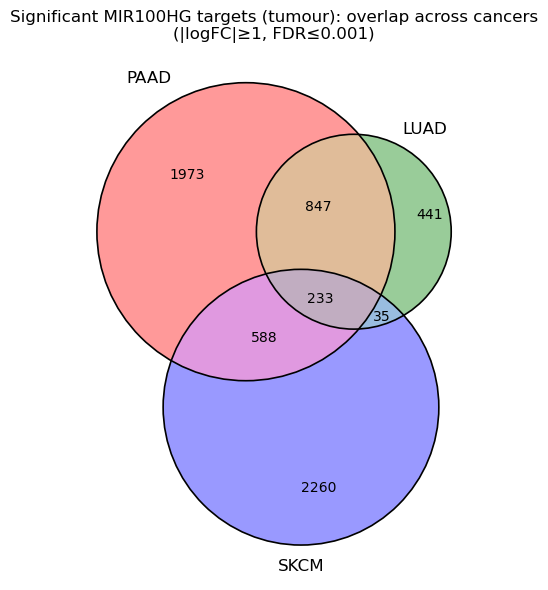

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/compare_pan_cancer/venn_targets_any_direction.png


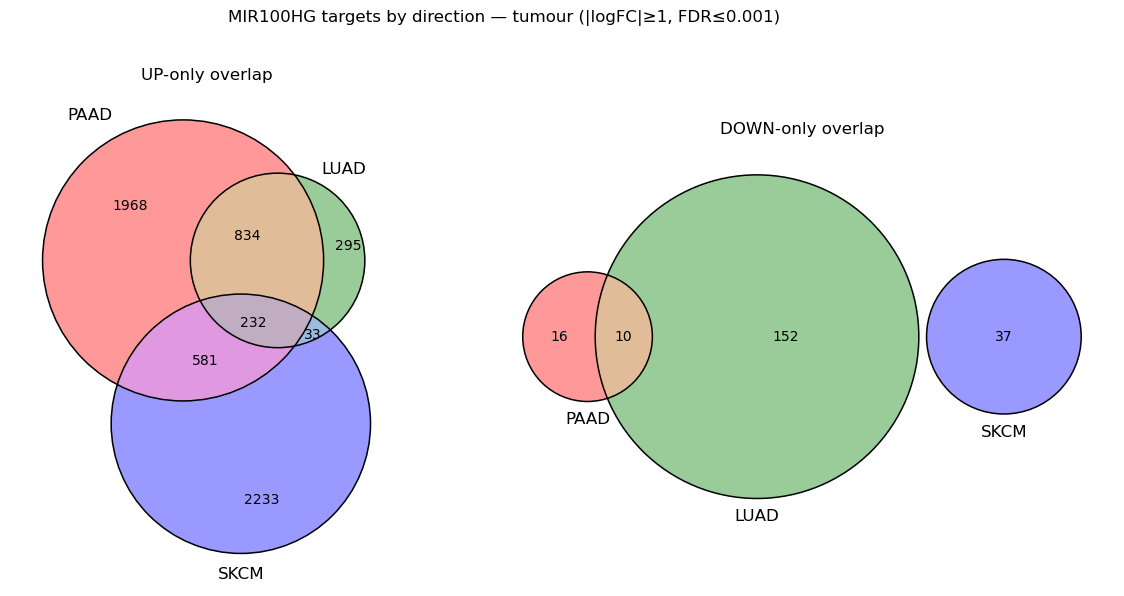

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/compare_pan_cancer/venn_targets_by_direction.png

[SUMMARY]
  PAAD sig: 3641 | LUAD sig: 1556 | SKCM sig: 3116
  Common all three (any direction): 233
  PAAD-only: 1973 | LUAD-only: 441 | SKCM-only: 2260
[DONE] Cross-cancer comparison complete. Outputs written to: /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/compare_pan_cancer


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PAAD_TUM = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/Paad_DEA/DEA_PAAD_Tumor_High_vs_Low_full_results.tsv"
PAAD_NOR = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/Paad_DEA_normal/DEA_GTEX_Pancreas_Normal_High_vs_Low_full_results.tsv"

LUAD_TUM = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_LUAD/DEA_LUAD_Tumor_High_vs_Low_full_results.tsv"
LUAD_NOR = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_LUAD/DEA_GTEX_Lung_Normal_High_vs_Low_full_results.tsv"

SKCM_TUM = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/DEA_SKCM_Tumor_High_vs_Low_full_results.tsv"
SKCM_NOR = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/DEA_GTEX_Skin_Normal_High_vs_Low_full_results.tsv"

OUTDIR = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/compare_pan_cancer"
os.makedirs(OUTDIR, exist_ok=True)

FDR_CUTOFF = 0.001
LFC_MIN    = 1.0

def _symcol(df: pd.DataFrame) -> str:
    for c in ["HGNC_symbol","Symbol","gene_symbol","Gene","gene_ID","Unnamed: 0"]:
        if c in df.columns:
            return c
    df["gene_ID"] = df.index.astype(str)
    return "gene_ID"

def _read_dea(path: str, tag: str) -> pd.DataFrame:
    """Read a DEA table and return Symbol + logFC/adj for this tag."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file for {tag}: {path}")
    df = pd.read_csv(path, sep="\t")
    sc = _symcol(df)
    # clean gene symbols like "ABC.1"
    df["Symbol"] = df[sc].astype(str).str.split(".").str[0].str.strip()
    df = df.dropna(subset=["Symbol"]).drop_duplicates("Symbol")
    # Keep only essential columns if present
    keep = {"Symbol","logFC","adj.P.Val"} & set(df.columns)
    df = df[list(keep)].copy()
    # Rename to tag-specific
    if "logFC" in df.columns:
        df.rename(columns={"logFC":f"logFC_{tag}"}, inplace=True)
    else:
        df[f"logFC_{tag}"] = np.nan
    if "adj.P.Val" in df.columns:
        df.rename(columns={"adj.P.Val":f"adj_{tag}"}, inplace=True)
    else:
        df[f"adj_{tag}"] = np.nan
    return df[["Symbol", f"logFC_{tag}", f"adj_{tag}"]]

paad_t = _read_dea(PAAD_TUM, "PAAD")
luad_t = _read_dea(LUAD_TUM, "LUAD")
skcm_t = _read_dea(SKCM_TUM, "SKCM")
paad_n = _read_dea(PAAD_NOR, "PAADN")
luad_n = _read_dea(LUAD_NOR, "LUADN")
skcm_n = _read_dea(SKCM_NOR, "SKCMN")

merged = (paad_t.merge(luad_t, on="Symbol", how="outer")
                .merge(skcm_t, on="Symbol", how="outer")
                .merge(paad_n, on="Symbol", how="outer")
                .merge(luad_n, on="Symbol", how="outer")
                .merge(skcm_n, on="Symbol", how="outer"))

TAGS = ["PAAD","LUAD","SKCM","PAADN","LUADN","SKCMN"]

for tag in TAGS:
    for col in (f"logFC_{tag}", f"adj_{tag}"):
        if col in merged.columns:
            merged[col] = pd.to_numeric(merged[col], errors="coerce")

for tag in TAGS:
    logc = merged[f"logFC_{tag}"]
    adjc = merged[f"adj_{tag}"]
    sig_mask = (~logc.isna()) & (~adjc.isna()) & (adjc <= FDR_CUTOFF) & (logc.abs() >= LFC_MIN)
    merged[f"dir_{tag}"] = np.where(sig_mask, np.where(logc >= LFC_MIN, "UP", "DOWN"), "NS")

tum_sig = {tag: set(merged.loc[merged[f"dir_{tag}"].ne("NS"), "Symbol"])
           for tag in ["PAAD","LUAD","SKCM"]}

from itertools import combinations
stats_rows = []
for a,b in combinations(["PAAD","LUAD","SKCM"], 2):
    A, B = tum_sig[a], tum_sig[b]
    inter = A & B
    union = A | B
    jacc = (len(inter)/len(union)) if union else 0.0
    
    if inter:
        sub = merged[merged.Symbol.isin(inter)]
        conc = float((sub[f"dir_{a}"] == sub[f"dir_{b}"]).mean())
    else:
        conc = np.nan
    stats_rows.append({
        "pair": f"{a}-{b}",
        f"{a}_sig_n": len(A),
        f"{b}_sig_n": len(B),
        "shared_n": len(inter),
        "jaccard": jacc,
        "direction_concordance": conc
    })
overlap_df = pd.DataFrame(stats_rows).sort_values("jaccard", ascending=False)
overlap_df.to_csv(os.path.join(OUTDIR, "tumour_overlap_stats.tsv"), sep="\t", index=False)

def _spearman(a, b):
    sub = merged.dropna(subset=[f"logFC_{a}", f"logFC_{b}"])
    return sub[f"logFC_{a}"].corr(sub[f"logFC_{b}"], method="spearman")

rho = {
    "PAAD-LUAD": _spearman("PAAD","LUAD"),
    "PAAD-SKCM": _spearman("PAAD","SKCM"),
    "LUAD-SKCM": _spearman("LUAD","SKCM"),
}
pd.Series(rho, name="spearman_rho").to_csv(os.path.join(OUTDIR, "spearman_logFC_pairwise.tsv"), sep="\t")

def _pick_signature(direction="UP", min_cancers=2):
    cols = ["dir_PAAD","dir_LUAD","dir_SKCM"]
    m = merged.copy()
    m["n_match"] = (m[cols].eq(direction)).sum(axis=1)
    return m.loc[m["n_match"]>=min_cancers, "Symbol"].dropna().unique().tolist()

pan_up   = _pick_signature("UP",   min_cancers=2)
pan_down = _pick_signature("DOWN", min_cancers=2)

paad_only = sorted(list(tum_sig["PAAD"] - (tum_sig["LUAD"] | tum_sig["SKCM"])))
luad_only = sorted(list(tum_sig["LUAD"] - (tum_sig["PAAD"] | tum_sig["SKCM"])))
skcm_only = sorted(list(tum_sig["SKCM"] - (tum_sig["PAAD"] | tum_sig["LUAD"])))

pd.Series(pan_up,   name="PanCancer_UP").to_csv(os.path.join(OUTDIR, "signature_pan_UP.tsv"), sep="\t", index=False)
pd.Series(pan_down, name="PanCancer_DOWN").to_csv(os.path.join(OUTDIR, "signature_pan_DOWN.tsv"), sep="\t", index=False)
pd.Series(paad_only, name="PAAD_only").to_csv(os.path.join(OUTDIR, "signature_PAAD_only.tsv"), sep="\t", index=False)
pd.Series(luad_only, name="LUAD_only").to_csv(os.path.join(OUTDIR, "signature_LUAD_only.tsv"), sep="\t", index=False)
pd.Series(skcm_only, name="SKCM_only").to_csv(os.path.join(OUTDIR, "signature_SKCM_only.tsv"), sep="\t", index=False)

merged.to_csv(os.path.join(OUTDIR, "merged_all_pan_cancer.tsv"), sep="\t", index=False)

def _save_list(lst, name):
    pd.Series(sorted(lst), name="Symbol").to_csv(os.path.join(OUTDIR, f"venn_{name}.tsv"),
                                                 sep="\t", index=False)

PAAD_sig = tum_sig["PAAD"]; LUAD_sig = tum_sig["LUAD"]; SKCM_sig = tum_sig["SKCM"]
common_all3 = PAAD_sig & LUAD_sig & SKCM_sig
paad_only   = PAAD_sig - (LUAD_sig | SKCM_sig)
luad_only   = LUAD_sig - (PAAD_sig | SKCM_sig)
skcm_only   = SKCM_sig - (PAAD_sig | LUAD_sig)

_save_list(common_all3, "COMMON_all3_anyDir")
_save_list(paad_only,   "PAAD_only_anyDir")
_save_list(luad_only,   "LUAD_only_anyDir")
_save_list(skcm_only,   "SKCM_only_anyDir")
_save_list(PAAD_sig & LUAD_sig, "PAIR_PAAD_LUAD_anyDir")
_save_list(PAAD_sig & SKCM_sig, "PAIR_PAAD_SKCM_anyDir")
_save_list(LUAD_sig & SKCM_sig, "PAIR_LUAD_SKCM_anyDir")


try:
    from matplotlib_venn import venn3, venn3_circles

    # Any-direction Venn
    plt.figure(figsize=(6.8, 6.0))
    venn3(subsets=(PAAD_sig, LUAD_sig, SKCM_sig), set_labels=("PAAD", "LUAD", "SKCM"))
    venn3_circles(subsets=(PAAD_sig, LUAD_sig, SKCM_sig), linewidth=1.2)
    plt.title("Significant MIR100HG targets (tumour): overlap across cancers\n(|logFC|≥1, FDR≤0.001)")
    plt.tight_layout()
    out_png = os.path.join(OUTDIR, "venn_targets_any_direction.png")
    plt.savefig(out_png, dpi=220)
    plt.show()
    print("[WRITE]", out_png)

    PAAD_up   = set(merged.loc[merged["dir_PAAD"].eq("UP"), "Symbol"])
    LUAD_up   = set(merged.loc[merged["dir_LUAD"].eq("UP"), "Symbol"])
    SKCM_up   = set(merged.loc[merged["dir_SKCM"].eq("UP"), "Symbol"])
    PAAD_down = set(merged.loc[merged["dir_PAAD"].eq("DOWN"), "Symbol"])
    LUAD_down = set(merged.loc[merged["dir_LUAD"].eq("DOWN"), "Symbol"])
    SKCM_down = set(merged.loc[merged["dir_SKCM"].eq("DOWN"), "Symbol"])

    _save_list(PAAD_up & LUAD_up & SKCM_up,       "COMMON_all3_UP")
    _save_list(PAAD_down & LUAD_down & SKCM_down, "COMMON_all3_DOWN")

    fig, axes = plt.subplots(1, 2, figsize=(12.5, 5.8))
    plt.sca(axes[0])
    venn3((PAAD_up, LUAD_up, SKCM_up), set_labels=("PAAD", "LUAD", "SKCM"))
    venn3_circles((PAAD_up, LUAD_up, SKCM_up), linewidth=1.1)
    plt.title("UP-only overlap")

    plt.sca(axes[1])
    venn3((PAAD_down, LUAD_down, SKCM_down), set_labels=("PAAD", "LUAD", "SKCM"))
    venn3_circles((PAAD_down, LUAD_down, SKCM_down), linewidth=1.1)
    plt.title("DOWN-only overlap")

    fig.suptitle("MIR100HG targets by direction — tumour (|logFC|≥1, FDR≤0.001)", y=1.02, fontsize=12)
    plt.tight_layout()
    out_png2 = os.path.join(OUTDIR, "venn_targets_by_direction.png")
    plt.savefig(out_png2, dpi=220, bbox_inches="tight")
    plt.show()
    print("[WRITE]", out_png2)

except ImportError:
    print("[INFO] matplotlib-venn not installed; skipping Venn plots. Install via: pip install matplotlib-venn")


print("\n[SUMMARY]")
print(f"  PAAD sig: {len(PAAD_sig)} | LUAD sig: {len(LUAD_sig)} | SKCM sig: {len(SKCM_sig)}")
print(f"  Common all three (any direction): {len(common_all3)}")
print(f"  PAAD-only: {len(paad_only)} | LUAD-only: {len(luad_only)} | SKCM-only: {len(skcm_only)}")
print("[DONE] Cross-cancer comparison complete. Outputs written to:", OUTDIR)


In [9]:
A, B, C = PAAD_sig, LUAD_sig, SKCM_sig
expected = {
    "100": len(A - B - C),
    "010": len(B - A - C),
    "001": len(C - A - B),
    "110": len((A & B) - C),
    "101": len((A & C) - B),
    "011": len((B & C) - A),
    "111": len(A & B & C),
}
print("[expected counts]", expected)

from matplotlib_venn import venn3
fig = plt.figure(); v = venn3((A,B,C), set_labels=("PAAD","LUAD","SKCM"))
drawn = {rid: (v.get_label_by_id(rid).get_text() if v.get_label_by_id(rid) else "0")
         for rid in ["100","010","001","110","101","011","111"]}
plt.close(fig)
print("[drawn labels]  ", drawn)


[expected counts] {'100': 1973, '010': 441, '001': 2260, '110': 847, '101': 588, '011': 35, '111': 233}
[drawn labels]   {'100': '1973', '010': '441', '001': '2260', '110': '847', '101': '588', '011': '35', '111': '233'}


In [11]:
common_up = merged.query('dir_PAAD=="UP" & dir_LUAD=="UP" & dir_SKCM=="UP"')["Symbol"].dropna().unique()
pd.Series(sorted(common_up), name="Symbol").to_csv(os.path.join(OUTDIR, "COMMON_all3_UP.tsv"), sep="\t", index=False)

common_down = merged.query('dir_PAAD=="DOWN" & dir_LUAD=="DOWN" & dir_SKCM=="DOWN"')["Symbol"].dropna().unique()
pd.Series(sorted(common_down), name="Symbol").to_csv(os.path.join(OUTDIR, "COMMON_all3_DOWN.tsv"), sep="\t", index=False)
